# Fase 2: Clasificación de la ejecución del movimiento
**Descripción**\
En esta segunda fase del proyecto, el objetivo es evaluar la correcta ejecución de los gestos identificados en la Fase 1. Después de haber determinado el mejor modelo para reconocer el tipo de gesto realizado por el paciente, ahora buscamos identificar si cada gesto se realiza correctamente o no.\
Este notebook aborda los siguientes aspectos:
* Creación de modelos: para cada tipo de gesto identificado en la Fase 1, se desarrollan modelos de clasificación separados, para determinar si un gesto es ejecutado de manera correcta o incorrecta
* Evaluación de la ejecución.

**Entrada**
* Datos de gestos procesados en el archivo ``medidasPerRepetition.csv``.

**Salida**
* Los resultados detallados del ajuste de modelos tras aplicar varias técnica de balanceo de datos se almacenan en el archivo ``Results_imblearn.txt``. 
* Nueve archivos `.sav`, uno para cada gesto, que almacenan el pipeline completo de clasificación entrenado, incluyendo tanto el preprocesamiento como el modelo final.

**Índice**
1. [Preprocesado](#1-preprocesado)
2. [Funciones adicionales](#2-funciones-adicionales)
3. [Balanceo de datos y modelos de clasificación](#3-balanceo-de-datos-y-modelos-de-clasificación)
4. [Pipeline](#4-pipeline)
****

In [1]:
# ---------- importar librerías---------
# Manipular los datos
import pandas as pd
import numpy as np

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

# scikit-learn (ML en python)
## Procesar el dataset
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import LeaveOneGroupOut # LeavePGroupsOut
## Modelos ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
## Evaluación de los modelos
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
## Hiperparametrizacion
from sklearn.model_selection import RandomizedSearchCV

# Class imbalance
from imblearn.under_sampling import NearMiss, EditedNearestNeighbours
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter

## Seleccion de variables
from sklearn.decomposition import PCA

# Pipeline
from imblearn.pipeline import Pipeline, make_pipeline


# Guardar modelos
import joblib

# Para ignorar los Warnings
import warnings
from sklearn.exceptions import FitFailedWarning 
warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
#---------Importar los datos-----------
# Dataframe medidas calculadas por repetición
df = pd.read_csv('../Resultados/medidasPerRepetition.csv', dtype=object)
df

,SubjectID,GestureLabel,GestureName,RepetitionNumber,CorrectLabel,Position,Duration,ArmsTogetherAngle_standardDeviation,WristAngleRight_standardDeviation,ShoulderAngleRight_standardDeviation,...,ElbowAngleLeft_Kurtosis,AnkleAngleLeft_Kurtosis,KneeAngleRight_Kurtosis,HipAngleRight_Kurtosis,RightArmAngle_Kurtosis,ElbowAngleRight_Kurtosis,ShoulderAngleLeft_Kurtosis,LeftArmAngle_Kurtosis,WristAngleLeft_Kurtosis,AnkleAngleRight_Kurtosis
0,102,0,EFL,1,1,stand,74,0.1772841364456791,10.26101242229342,3.294713554484951,...,0.0031651605219784607,-0.9218459378889565,-0.15931125809206037,-1.2130443787023806,0.22147301566722177,-1.4904572038164694,-1.2511436779592484,-0.9889825587727601,0.49064396646617325,15.481423750569686
1,102,0,EFL,2,1,stand,64,0.4263728019753976,14.450470086179894,4.742959999419659,...,-0.37276591142763404,-1.415922318356331,-0.7952358950848302,0.1663793296511078,-1.4860333958071466,-1.431169382708514,-0.472467253988782,-1.2938450639789785,-0.4820511677254036,30.5994648202742
2,102,0,EFL,3,1,stand,58,0.3042598022496037,19.336369323958806,5.070927804652568,...,-0.7468858689852,-1.2031165908034858,-0.6294624577289896,-1.3046791681113268,-0.7913285454951731,-1.4481284878299678,-0.80871088359656,-1.2447151128330012,-0.4600530042376674,2.3465174536000597
3,102,0,EFL,4,1,stand,60,0.3995792188585782,25.598713023913547,4.030705303230586,...,-0.43473169212731255,-1.515334441103624,-0.8623099615734113,0.005323712651228885,0.2021513530164274,-1.5858806918810486,-1.177012012109949,-1.5331879897259844,-0.8802435890745861,7.285594611894105
4,102,0,EFL,5,1,stand,63,0.27963754747768604,17.18236360360904,5.0214031977910025,...,-0.6246555005572025,-0.5172894066010225,-0.7211398634607731,-0.4846351691232118,0.8374033797172151,-1.4608887020665993,-0.6891877979451944,-1.2588672287903098,0.24772473501311465,15.865257246460724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,307,8,STR,8,1,stand,48,0.7009881141454974,2.466577348177862,0.31117453250813193,...,-0.872651262794327,0.3128612914678124,-0.03871838482689416,-1.0147459156385952,-1.3135876318761117,0.2349362671803661,-0.9711951091789164,-0.7819445228324606,-0.9497548154180149,-0.27096393159111365
2478,307,8,STR,9,1,stand,48,1.0474239581808693,3.8105919022834787,0.3149865690386516,...,-1.114746529982971,1.0563069343178357,-1.1950256619427102,-1.6514620789341043,-1.5516197804042655,-0.7599906379430719,-0.9634116877073748,-1.6440947148894454,0.5206579931780264,-1.671158809245181
2479,307,8,STR,10,1,stand,47,0.9896564331899043,2.2038654101046444,0.2992096802502965,...,-0.26707616144666035,-0.8511193505749479,-0.4710997071899854,-1.1035174398755037,-1.482760099972705,-0.7075858254569143,0.037584168596986434,-0.8260053251206552,-0.8342729804592226,-2.0619974765610145
2480,307,8,STR,11,1,stand,51,1.1787018901548965,2.6097957208124978,0.18962361977080142,...,-0.9831781122705068,-0.15679385214543773,-0.2748779324865849,-1.697379934669209,-1.3479547821640623,-0.8992526018749398,-0.6604779230069129,-0.6200231953842121,-0.26102617707178055,-1.0110640151752714


*****
## 1. Preprocesado

In [3]:
# ------Preparar el dataset-------
# df = df.drop(['GestureName'], axis=1)

encoder = OrdinalEncoder(categories=[list(set(df["Position"].values))])
encoder.fit(df[["Position"]])
df["Position"] = encoder.transform(df[["Position"]])

# pasar variable obj to numeric
df = df.apply(pd.to_numeric, errors='ignore')

# cambiar las poorly executed to incorrectly executed
df[df['CorrectLabel']==3] = 2

****
## 2. Funciones adicionales

In [4]:
#-------Funciones--------

# dividir en test y train df_gestures
def split_df_gestures(df:pd.DataFrame, target: str):
    """
    Divide un DataFrame en conjuntos de entrenamiento y prueba basados en los valores de 'SubjectID'.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame que contiene los datos completos incluyendo características y el target.
    target : str
        Nombre de la columna objetivo que contiene las etiquetas de la clase.

    Return
    -------
    X_train : pd.DataFrame
        Conjunto de datos de entrenamiento con las características (sin la columna objetivo).
    X_test : pd.DataFrame
        Conjunto de datos de prueba con las características (sin la columna objetivo).
    y_train : np.ndarray
        Array 1D con las etiquetas del conjunto de entrenamiento.
    y_test : np.ndarray
        Array 1D con las etiquetas del conjunto de prueba.
    """
    # Selecciona los datos de prueba (varios sujetos)
    test_df = df.loc[(df.SubjectID==102) | (df.SubjectID==105) | (df.SubjectID==201) |
                (df.SubjectID==202) | (df.SubjectID==205) | (df.SubjectID==211) |(df.SubjectID==301) | (df.SubjectID==302)] 

    # Selecciona los datos de entrenamiento excluyendo los mismos sujetos
    train_df = df.loc[(df.SubjectID!=102) & (df.SubjectID!=105)  & (df.SubjectID!=201) &
                    (df.SubjectID!=202) & (df.SubjectID!=205) & (df.SubjectID!=211) & (df.SubjectID!=301) & (df.SubjectID!=302)]

    # Separa las características y las etiquetas en el conjunto de entrenamiento
    X_train = train_df.drop([target], axis=1)  
    y_train = pd.DataFrame(train_df[target])   

    # Separa las características y las etiquetas en el conjunto de prueba
    X_test = test_df.drop([target], axis=1)  
    y_test = pd.DataFrame(test_df[target])   

    # Convierte los DataFrames de etiquetas a arrays 1D
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    # Devuelve los conjuntos de entrenamiento y prueba
    return X_train, X_test, y_train, y_test

# Para entrenar los modelos de ML
def aplicar_modelos(X: pd.DataFrame, y: np.ndarray, tX: pd.DataFrame, ty: np.ndarray, file):
    """
    Entrena y evalua una lista de modelos deaprendizaje automático,\\
    guardando los resultados en una archivo

    Parámetros
    ----------
    X : pd.DataFrame
        Conjunto de datos de entrenamiento con las características (variables independientes).
    y : np.ndarray
        Array con las etiquetas (valores de salida) del conjunto de entrenamiento.
    tX : pd.DataFrame
        Conjunto de datos de prueba con las características.
    ty : np.ndarray
        Array con las etiquetas verdaderas del conjunto de prueba.
    file : archivo
        Objeto de archivo abierto para escribir los resultados.
    """
    # creación de los modelos
    knn = KNeighborsClassifier()  # K-Neighbors classifier
    dtree = DecisionTreeClassifier()  # Decision tree
    nb = GaussianNB()  # Naive Bayes
    svm = SVC(probability=True)  # Support Vector Machine
    rf = RandomForestClassifier()  # Random Forest
    lr = LogisticRegression()  # Logistic Regression

    models = [knn, dtree, nb, svm, rf, lr]

    # Método de validación cruzada Leave-One-Group-Out basado en SubjectID
    logo = LeaveOneGroupOut()
    grupos = X['SubjectID']

    # Iteramos sobre los modelos
    for modelo in models:
        # Evaluación de modelos mediante validación cruzada
        accuracy_scores = cross_val_score(modelo, X, y, groups=grupos, cv=logo, scoring='accuracy')
        f1_scores = cross_val_score(modelo, X, y, groups=grupos, cv=logo, scoring='f1')
        
        # Escribiendo los resultados de la validación cruzada en el archivo
        file.write(f"\nModelo: {modelo.__class__.__name__}\n")
        file.write(f"Precision media: {accuracy_scores.mean():.2f} con una desviacion estandar de {accuracy_scores.std():.2f}\n")
        file.write(f"F1-score media: {f1_scores.mean():.2f} con una desviacion estandar de {f1_scores.std():.2f}\n")

        # Evaluación final en el conjunto de prueba
        modelo.fit(X, y)  # Entrenamos el modelo con todos los datos de entrenamiento
        prediction = modelo.predict(tX)  # Predicciones en los datos de prueba
        score = f1_score(ty, prediction, average='weighted', zero_division=0) 
        file.write(f"Evaluacion en conjunto de prueba (F1-score ponderado): {score:.2f}\n")
        y_prob = modelo.predict_proba(tX)[:, 1]
        fpr, tpr, _ = roc_curve(ty, y_prob, pos_label = 2) 
        roc_auc = auc(fpr, tpr)
        file.write(f"AUC del conjunto de prueba: {roc_auc:.2f}\n")


# Aplicar imbalance learn
def aplicar_imblearn(X: pd.DataFrame, y: np.ndarray,  tX: pd.DataFrame, ty: np.ndarray, file):
    """
    Aplica una lista de técnicas de balanceo de datos para abordar el desbalance de clases.

    Parámetros
    ----------
    X : pd.DataFrame
        Conjunto de datos de entrenamiento con las características (variables independientes).
    y : np.ndarray
        Array con las etiquetas (valores de salida) del conjunto de entrenamiento.
    tX : pd.DataFrame
        Conjunto de datos de prueba con las características.
    ty : np.ndarray
        Array con las etiquetas verdaderas del conjunto de prueba.
    file : archivo
        Objeto de archivo abierto para escribir los resultados.
    """
    # Definición de las técnicas de resampling de imbalanced-learn
    nm1 = NearMiss(version=1, n_neighbors=2)  # Undersampling: NearMiss versión 1
    enn = EditedNearestNeighbours()  # Undersampling: Edited Nearest Neighbours
    adasyn = ADASYN(n_neighbors=2)  # Oversampling: Adaptive Synthetic Sampling (ADASYN)
    smote = SMOTE(k_neighbors=2)  # Oversampling: Synthetic Minority Over-sampling Technique (SMOTE)
    smotetomek = SMOTETomek(smote=smote)  # Combinación de SMOTE y Tomek links (sobremuestreo y eliminación de ruido)
    smote_enn = SMOTEENN(smote=smote)  # Combinación de SMOTE y Edited Nearest Neighbours (sobremuestreo y eliminación de ruido)

    # Lista de técnicas de resampling
    imblearns = [nm1, enn, adasyn, smote, smotetomek, smote_enn]

    # Aplicación de cada técnica de resampling
    for imblearn in imblearns:
        # Resamplear los datos
        X_im, y_im = imblearn.fit_resample(X, y)
        
        # Escribir resultados en el archivo
        file.write(f"\n\t- Tecnica de Resampling: {imblearn.__class__.__name__}\n")
        file.write(f"Distribucion de etiquetas antes del resampling: {Counter(y)}\n")
        file.write(f"Distribucion de etiquetas despues del resampling: {Counter(y_im)}\n")

        # Aplicar modelos a los datos tras resamplear
        aplicar_modelos(X_im, y_im, tX, ty, file)

****
## 3. Balanceo de datos y modelos de clasificación

In [10]:
gestures = df['GestureLabel'].unique()

# Abre el archivo 'Results_imblearn.txt' para escribir los resultados
with open('../Resultados/Results_imblearn.txt', 'w') as file:
    # Itera sobre los gestos
    for gesture in gestures:
        # Filtra el DataFrame para obtener solo las filas correspondientes al gesto
        df_gesture = df[df['GestureLabel'] == gesture]
        gesture_name = df_gesture['GestureName'].unique()[0]
        df_gesture = df_gesture.drop(['GestureName'], axis=1) 

        # Divide el DataFrame en conjuntos de entrenamiento y prueba
        X_train, X_test, y_train, y_test = split_df_gestures(df_gesture, 'CorrectLabel')  

        file.write(f'\n------------ CLASIFICACION GESTO {gesture_name} -----------\n')
        aplicar_imblearn(X_train, y_train, X_test, y_test, file)

Después de evaluar los resultados en el archivo de salida ``Results_imblearn.txt``, se determinó que la técnica de balanceo de datos con mejor rendimiento es **SMOTETomek** y **SMOTEENN**. Por lo tanto, se utilizará esta técnica para generar y presentar los nuevos datos balanceados.

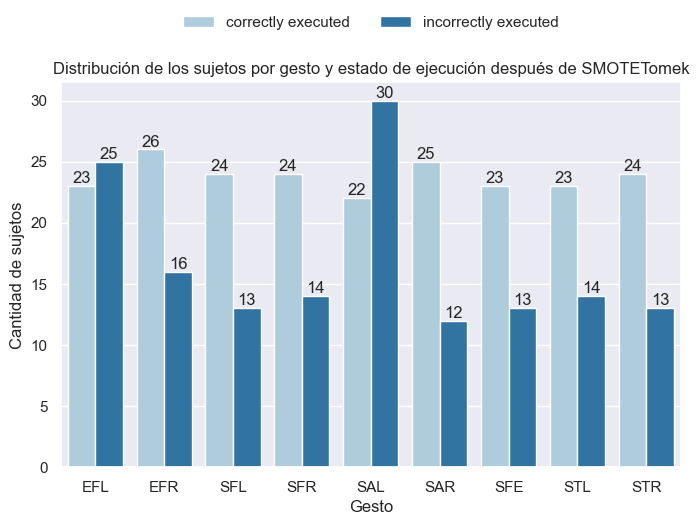

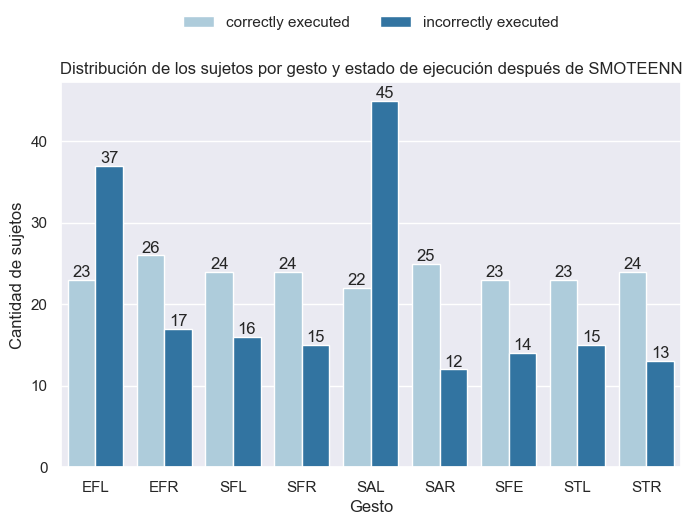

In [6]:
# -------- Aplicar imblearn ---------------
smotetomek = SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))
smoteenn = SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))

# Separar las características y las etiquetas
X = df.drop(['CorrectLabel'], axis=1) 
y = pd.DataFrame(df['CorrectLabel'])

all_data = pd.DataFrame()
for resampler in [smotetomek, smoteenn]:
    for gesture in gestures:
        # Filtra el DataFrame para obtener solo las filas correspondientes al gesto
        df_gesture = df[df['GestureLabel'] == gesture]
        df_gesture = df_gesture.drop(['GestureName'], axis=1) 
    
        # Separar las características y las etiquetas
        X = df_gesture.drop(['CorrectLabel'], axis=1) 
        y = pd.DataFrame(df_gesture['CorrectLabel'])

        # Resamplear los datos para balancear las clases
        X_resampled, y_resampled = resampler.fit_resample(X, y)

        balanced_data = pd.concat([X_resampled, y_resampled], axis=1)
        all_data = pd.concat([all_data, balanced_data], axis=0)

    # Reset the index of the final balanced DataFrame
    all_data.reset_index(drop=True, inplace=True)

    # Calcular la cantidad de sujetos únicos por gesto y estado de ejecución
    subject_count_per_gesture_correct = all_data.groupby(["GestureLabel", "CorrectLabel"])["SubjectID"].nunique().reset_index()

    # Gráficar la distribución de sujetos después de aplicar SMOTETomek
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x="GestureLabel", y="SubjectID", hue="CorrectLabel",
                    data=subject_count_per_gesture_correct, palette="Paired")

    # Configurar el título y las etiquetas de los ejes
    ax.set_title(f"Distribución de los sujetos por gesto y estado de ejecución después de {resampler.__class__.__qualname__}")
    ax.set_xlabel("Gesto")
    ax.set_ylabel("Cantidad de sujetos")

    # Configurar las etiquetas de la x-axis con los nombres de gestos 
    gesture_labels = ['EFL', 'EFR', 'SFL', 'SFR', 'SAL', 'SAR', 'SFE', 'STL', 'STR']
    ax.set_xticklabels(gesture_labels)

    # Modificar las etiquetas de la leyenda
    legend_labels = ['correctly executed', 'incorrectly executed', 'poorly executed']
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=legend_labels, title='Execution')
    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, 1.1), ncol=2, title=None, frameon=False,
    )

    # Añadir etiquetas de conteo encima de cada barra en el gráfico
    for i in ax.containers:
        ax.bar_label(i,)

    plt.show()

****
## 4. Pipeline

Creación de pipelines que incluyen técnicas de balanceo de datos, reducción de dimensión y clasificación. Además, se emplea ``RandomizedSearchCV`` para encontrar la mejor combinación de hiperparámetros para cada pipeline.\
Los modelos optimizados se evalúan utilizando métricas de rendimiento, incluyendo la curva ROC y el área bajo la curva (AUC), para cada gesto.


------------ CLASIFICACION GESTO EFL -----------

F1-score del conjunto de entrenamiento: 0.9
F1-score del conjunto de prueba: 0.9565217391304348
Pipeline(steps=[('balance_data',
                 SMOTETomek(smote=SMOTE(k_neighbors=4, sampling_strategy=1.0))),
                ('reduce_dim', PCA(n_components=0.5)),
                ('classifier',
                 GaussianNB(var_smoothing=5.590810182512223e-06))])


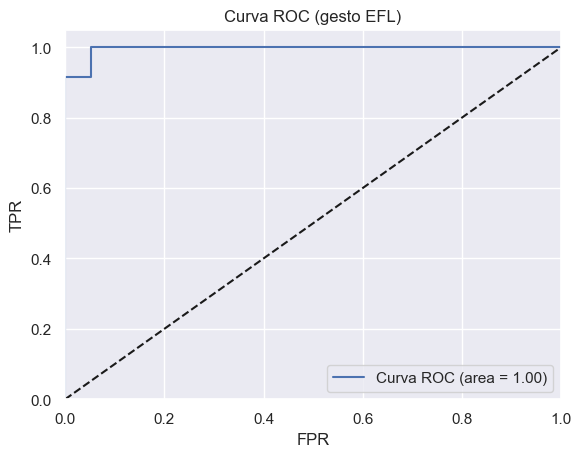


------------ CLASIFICACION GESTO EFR -----------

F1-score del conjunto de entrenamiento: 0.8715083798882681
F1-score del conjunto de prueba: 0.8735632183908046
Pipeline(steps=[('balance_data',
                 SMOTEENN(smote=SMOTE(k_neighbors=4, sampling_strategy=1.0))),
                ('reduce_dim', PCA(n_components=0.5)),
                ('classifier', LogisticRegression(C=100, max_iter=500))])


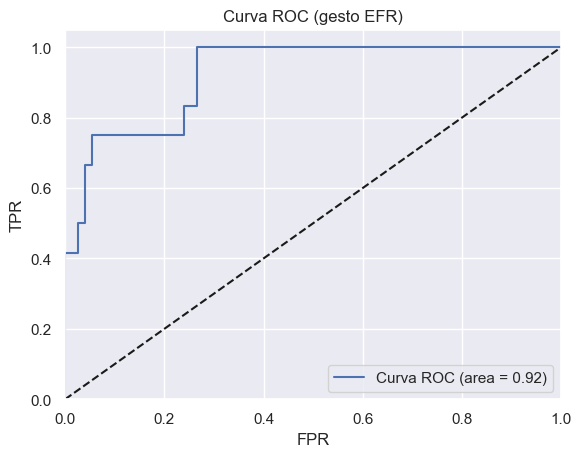


------------ CLASIFICACION GESTO SFL -----------

F1-score del conjunto de entrenamiento: 0.8836363636363637
F1-score del conjunto de prueba: 0.79
Pipeline(steps=[('balance_data',
                 SMOTETomek(smote=SMOTE(k_neighbors=4, sampling_strategy=1.0))),
                ('reduce_dim', PCA(n_components=0.8)),
                ('classifier', SVC(C=100, kernel='sigmoid', probability=True))])


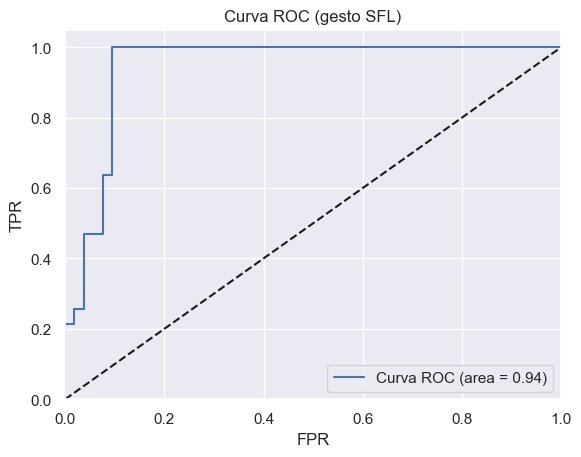


------------ CLASIFICACION GESTO SFR -----------

F1-score del conjunto de entrenamiento: 0.9612068965517241
F1-score del conjunto de prueba: 0.9726027397260274
Pipeline(steps=[('balance_data',
                 SMOTEENN(smote=SMOTE(k_neighbors=4, sampling_strategy=1.0))),
                ('reduce_dim', PCA(n_components=0.5)),
                ('classifier',
                 GaussianNB(var_smoothing=0.0025950242113997346))])


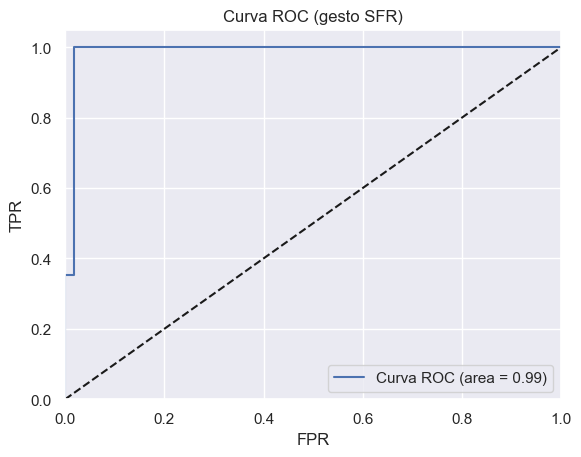


------------ CLASIFICACION GESTO SAL -----------

F1-score del conjunto de entrenamiento: 0.7757575757575758
F1-score del conjunto de prueba: 0.7346938775510204
Pipeline(steps=[('balance_data',
                 SMOTETomek(smote=SMOTE(k_neighbors=3, sampling_strategy=1.0))),
                ('reduce_dim', PCA(n_components=0.5)),
                ('classifier',
                 GaussianNB(var_smoothing=0.0007054802310718639))])


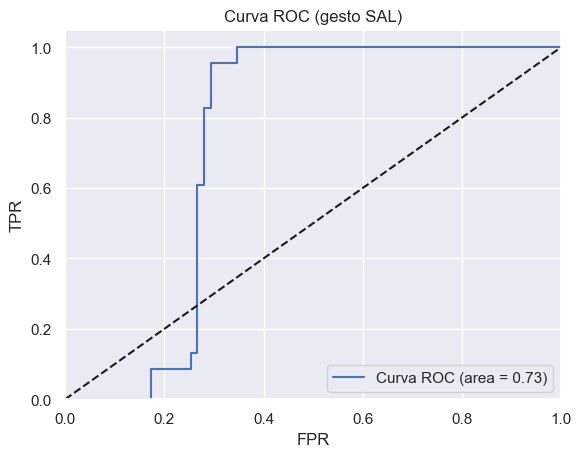


------------ CLASIFICACION GESTO SAR -----------

F1-score del conjunto de entrenamiento: 0.842391304347826
F1-score del conjunto de prueba: 0.9833333333333333
Pipeline(steps=[('balance_data',
                 SMOTEENN(smote=SMOTE(k_neighbors=4, sampling_strategy=1.0))),
                ('reduce_dim', PCA(n_components=0.7)),
                ('classifier',
                 GaussianNB(var_smoothing=6.734150657750815e-06))])


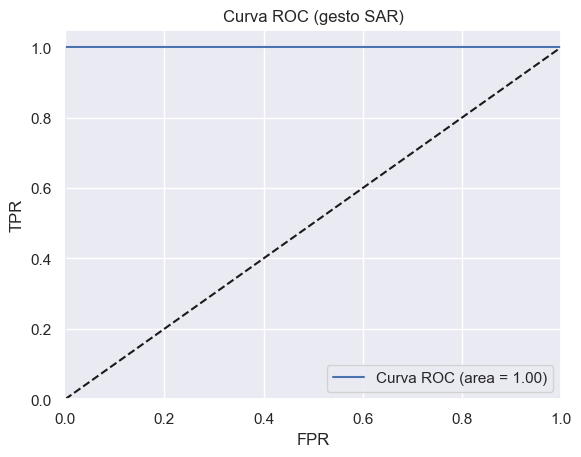


------------ CLASIFICACION GESTO SFE -----------

F1-score del conjunto de entrenamiento: 0.8633879781420765
F1-score del conjunto de prueba: 0.9523809523809523
Pipeline(steps=[('balance_data',
                 SMOTEENN(smote=SMOTE(k_neighbors=3, sampling_strategy=1.0))),
                ('reduce_dim', PCA(n_components=0.5)),
                ('classifier',
                 GaussianNB(var_smoothing=1.9630406500402685e-07))])


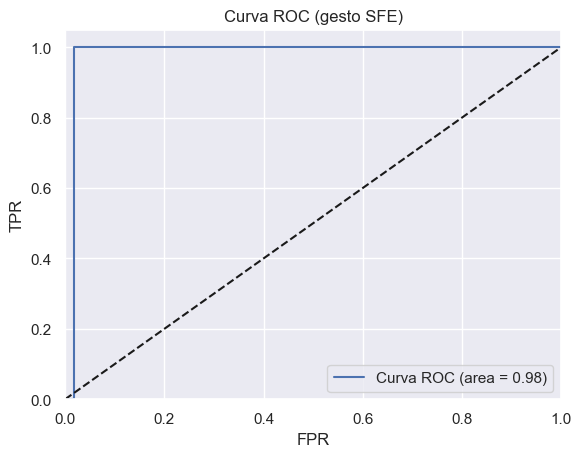


------------ CLASIFICACION GESTO STL -----------

F1-score del conjunto de entrenamiento: 0.19444444444444445
F1-score del conjunto de prueba: 0.1518987341772152
Pipeline(steps=[('balance_data',
                 SMOTEENN(smote=SMOTE(k_neighbors=3, sampling_strategy=1.0))),
                ('reduce_dim', PCA(n_components=0.8)),
                ('classifier', GaussianNB(var_smoothing=0.32745491628777285))])


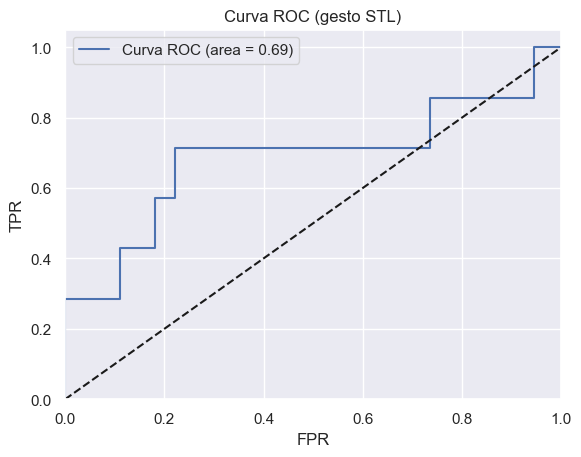


------------ CLASIFICACION GESTO STR -----------

F1-score del conjunto de entrenamiento: 0.5804597701149425
F1-score del conjunto de prueba: 0.7227722772277227
Pipeline(steps=[('balance_data',
                 SMOTEENN(smote=SMOTE(k_neighbors=4, sampling_strategy=1.0))),
                ('reduce_dim', PCA(n_components=0.9)),
                ('classifier',
                 GaussianNB(var_smoothing=2.205130739903041e-06))])


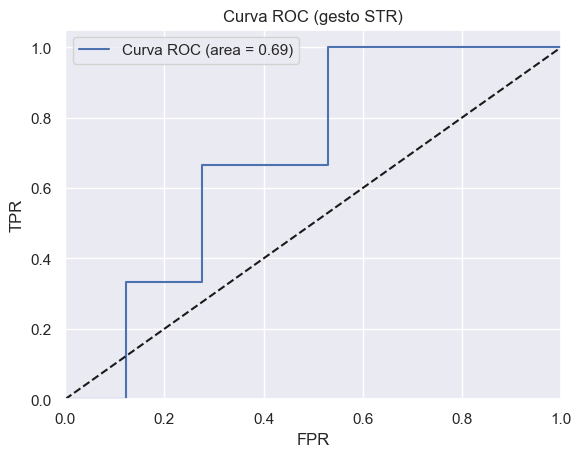

In [7]:
# Definir la malla de parámetros
param_grid = [
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=3, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=3, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'reduce_dim__n_components': [0.5, 0.7, 0.8, 0.90, 1],
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [2, 3, 5], 
        'classifier__weights': ['uniform', 'distance'], 
        'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=3, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=3, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'reduce_dim__n_components': [0.5, 0.7, 0.8, 0.90, 1],
        'classifier': [DecisionTreeClassifier()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [None, 10, 20, 30]
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=3, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=3, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'reduce_dim__n_components': [0.5, 0.7, 0.8, 0.90, 1],
        'classifier': [GaussianNB()],
        'classifier__var_smoothing': np.logspace(0, -8, num=100)
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=3, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=3, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'reduce_dim__n_components': [0.5, 0.7, 0.8, 0.90, 1],
        'classifier': [SVC(probability=True)],
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'classifier__C': [0.1, 1, 10, 100]
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=3, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=3, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'reduce_dim__n_components': [0.5, 0.7, 0.8, 0.90, 1],
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [200, 300],
        'classifier__max_features': ['sqrt', 'log2']
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=3, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=3, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'reduce_dim__n_components': [0.5, 0.7, 0.8, 0.90, 1],
        'classifier': [LogisticRegression(max_iter=500)],
        'classifier__C': [0.01, 0.1, 1, 10, 100]
    }
]

# Definir Leave-One-Group-Out cross-validation
logo = LeaveOneGroupOut()

# Iterar sobre cada gesto único
for gesture in gestures:

    df_gesture = df[df['GestureLabel'] == gesture]
    gesture_name = df_gesture['GestureName'].unique()[0]
    df_gesture = df_gesture.drop(['GestureName'], axis=1) 
    df_gesture = df_gesture.drop(['GestureLabel'], axis=1)
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = split_df_gestures(df_gesture, 'CorrectLabel')

    print(f'\n------------ CLASIFICACION GESTO {gesture_name} -----------\n')

    # Crear el pipeline con técnicas de balanceo, reducción de dimensión y modelo de clasificación
    pipeline = Pipeline([('balance_data',  SMOTETomek(smote=SMOTE(k_neighbors=3, sampling_strategy=1.0))),
                        ('reduce_dim', PCA()),
                        ('classifier', KNeighborsClassifier(n_neighbors=2))])

    # RandomizedSearchCV para encontrar los mejores hiperparámetros
    random = RandomizedSearchCV(pipeline, param_grid, cv=logo,
                                n_jobs=-1, n_iter=5, scoring='roc_auc')
    random.fit(X_train, y_train, groups=X_train['SubjectID'])
    # Mejor pipeline encontrado
    best_pipeline = random.best_estimator_

    # Evaluar el modelo en el conjunto de entrenamiento y prueba
    print(f'F1-score del conjunto de entrenamiento: {best_pipeline.score(X_train, y_train)}')
    print(f'F1-score del conjunto de prueba: {best_pipeline.score(X_test, y_test)}')
    print(best_pipeline)

    # Calcular la curva ROC
    y_prob = best_pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label = 2) 
    roc_auc = auc(fpr, tpr)

    # guardar el modelo entrenado
    if roc_auc >= 0.65:
        filename = f'../Resultados/modelo_{gesture_name}.sav'
        joblib.dump(make_pipeline(encoder, best_pipeline), filename)

    # Graficar la curva ROC
    plt.figure()  
    plt.plot(fpr, tpr, label='Curva ROC (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'Curva ROC (gesto {gesture_name})')
    plt.legend()
    plt.show()